# Twitter Sentiment Analysis: EDA 
### Importing Libraries

In [120]:
import pandas as pd
import numpy as np
import nltk
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import itertools as it
import re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_content']
twitter_training = pd.read_csv('twitter_training.csv', sep=',', names=column_names)
twitter_validation= pd.read_csv('twitter_validation.csv', sep=',', names=column_names)

### - Exploration of each dataset

In [4]:
twitter_training.head(3)

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [5]:
twitter_training.tail(3)

,Tweet_ID,Entity,Sentiment,Tweet_content
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...
74681,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [7]:
twitter_validation.head(3)

,Tweet_ID,Entity,Sentiment,Tweet_content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...


In [8]:
twitter_validation.tail(3)

,Tweet_ID,Entity,Sentiment,Tweet_content
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.
999,6960,johnson&johnson,Neutral,Johnson & Johnson to stop selling talc baby po...


In [9]:
# remove dupicate and nan values
twitter_training.dropna(inplace=True)
twitter_training.drop_duplicates(inplace=True)

In [10]:
twitter_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71656 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       71656 non-null  int64 
 1   Entity         71656 non-null  object
 2   Sentiment      71656 non-null  object
 3   Tweet_content  71656 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [11]:
twitter_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       1000 non-null   int64 
 1   Entity         1000 non-null   object
 2   Sentiment      1000 non-null   object
 3   Tweet_content  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [13]:
#remove urls & special characters
def remove_urls(text):
    """Berilgan matndan URL larini o'chiradi"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_emojis(text):
    """Berilgan matndan emojilarni o'chiradi"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emojilar
                               u"\U0001F300-\U0001F5FF"  # simvollar va diagrammalar
                               u"\U0001F680-\U0001F6FF"  # transport va turli joylar
                               u"\U0001F1E0-\U0001F1FF"  # davlat bayroqlari
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # alamatchilik belgilari
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
#def remove_and,or,a,the...

In [14]:
twitter_training['Tweet_content'] = twitter_training['Tweet_content'].apply(lambda x: remove_emojis(x))
twitter_training['Tweet_content'] = twitter_training['Tweet_content'].apply(lambda x: remove_urls(x))

twitter_validation['Tweet_content'] = twitter_validation['Tweet_content'].apply(lambda x: remove_emojis(x))
twitter_validation['Tweet_content'] = twitter_validation['Tweet_content'].apply(lambda x: remove_urls(x))

In [15]:
twitter_training['text_lens']=twitter_training['Tweet_content'].apply(lambda x: len(x))
twitter_validation['text_lens']=twitter_validation['Tweet_content'].apply(lambda x: len(x))

In [19]:
#Count information per category
data1=twitter_training.groupby(by=["Entity","Sentiment"]).count().reset_index()
data1.head()

,Entity,Sentiment,Tweet_ID,Tweet_content,text_lens
0,Amazon,Irrelevant,185,185,185
1,Amazon,Negative,565,565,565
2,Amazon,Neutral,1197,1197,1197
3,Amazon,Positive,302,302,302
4,ApexLegends,Irrelevant,185,185,185


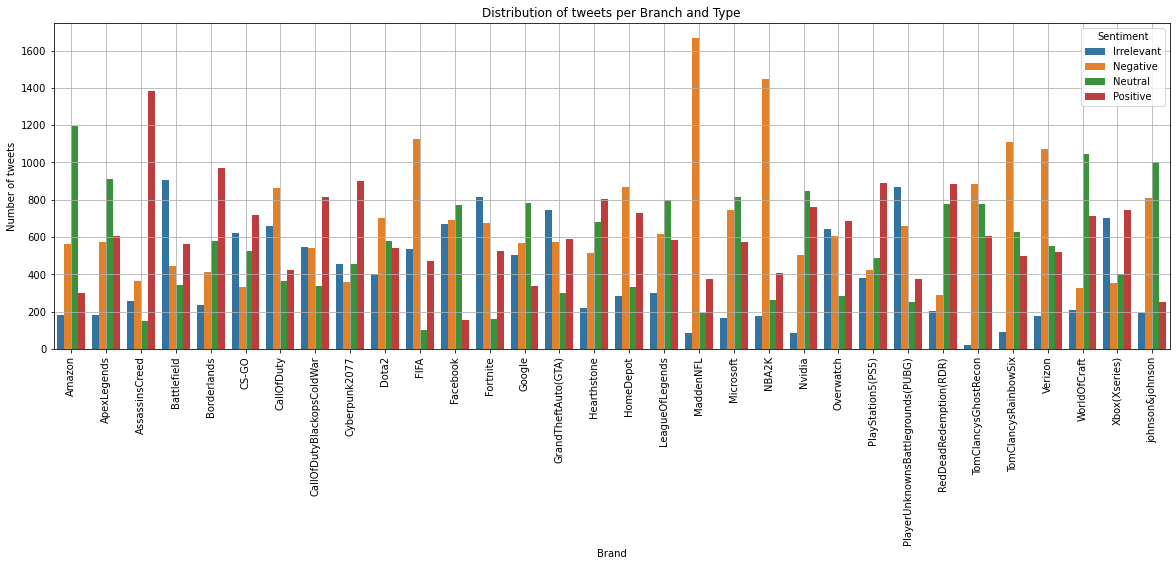

In [14]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=data1,x="Entity",y="Tweet_ID",hue='Sentiment')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")
plt.show()

#### - Data Preprocessing for Medeling

In [108]:
twitter_training['Tweet_content'] = [word.lower() for word in twitter_training['Tweet_content']]
twitter_training['Tweet_content']

0        im getting on borderlands and i will murder yo...
1        i am coming to the borders and i will kill you...
2        im getting on borderlands and i will kill you ...
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
74677    just realized that the windows partition of my...
74678    just realized that my mac window partition is ...
74679    just realized the windows partition of my mac ...
74680    just realized between the windows partition of...
74681    just like the windows partition of my mac is l...
Name: Tweet_content, Length: 71656, dtype: object

In [109]:
#Tokenize every entry in the data set
tokenized_twitter_training = [word_tokenize(word) for word in twitter_training['Tweet_content']]

#Transforming into a single list
tokenized_twitter_training = list(map(str, it.chain.from_iterable(tokenized_test_song)))
tokenized_twitter_training

['im',
 'getting',
 'on',
 'borderlands',
 'and',
 'i',
 'will',
 'murder',
 'you',
 'all',
 ',',
 'i',
 'am',
 'coming',
 'to',
 'the',
 'borders',
 'and',
 'i',
 'will',
 'kill',
 'you',
 'all',
 ',',
 'im',
 'getting',
 'on',
 'borderlands',
 'and',
 'i',
 'will',
 'kill',
 'you',
 'all',
 ',',
 'im',
 'coming',
 'on',
 'borderlands',
 'and',
 'i',
 'will',
 'murder',
 'you',
 'all',
 ',',
 'im',
 'getting',
 'on',
 'borderlands',
 '2',
 'and',
 'i',
 'will',
 'murder',
 'you',
 'me',
 'all',
 ',',
 'im',
 'getting',
 'into',
 'borderlands',
 'and',
 'i',
 'can',
 'murder',
 'you',
 'all',
 ',',
 'so',
 'i',
 'spent',
 'a',
 'few',
 'hours',
 'making',
 'something',
 'for',
 'fun',
 '.',
 '.',
 '.',
 'if',
 'you',
 'do',
 "n't",
 'know',
 'i',
 'am',
 'a',
 'huge',
 '@',
 'borderlands',
 'fan',
 'and',
 'maya',
 'is',
 'one',
 'of',
 'my',
 'favorite',
 'characters',
 '.',
 'so',
 'i',
 'decided',
 'to',
 'make',
 'myself',
 'a',
 'wallpaper',
 'for',
 'my',
 'pc',
 '.',
 '.',
 'her

In [110]:
# Removing stopwords, punctuation and numbers
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list += ['....','...', '..', '’', "''", '``', '-',"([a-zA-Z]+(?:'[a-z]+)?)"]
tokenized_twitter_training_stopped = [word for word in tokenized_twitter_training if word not in stopwords_list]
tokenized_twitter_training_stopped

['im',
 'getting',
 'borderlands',
 'murder',
 'coming',
 'borders',
 'kill',
 'im',
 'getting',
 'borderlands',
 'kill',
 'im',
 'coming',
 'borderlands',
 'murder',
 'im',
 'getting',
 'borderlands',
 'murder',
 'im',
 'getting',
 'borderlands',
 'murder',
 'spent',
 'hours',
 'making',
 'something',
 'fun',
 "n't",
 'know',
 'huge',
 'borderlands',
 'fan',
 'maya',
 'one',
 'favorite',
 'characters',
 'decided',
 'make',
 'wallpaper',
 'pc',
 'original',
 'image',
 'versus',
 'creation',
 'made',
 'enjoy',
 'pic.twitter.com/mlsi5wf9jg',
 'spent',
 'couple',
 'hours',
 'something',
 'fun',
 "n't",
 'know',
 "'m",
 'huge',
 'borderlands',
 'fan',
 'maya',
 'one',
 'favorite',
 'characters',
 'decided',
 'make',
 'wallpaper',
 'pc',
 "'s",
 'original',
 'picture',
 'compared',
 'creation',
 'made',
 'fun',
 'pic.twitter.com',
 'mlsi5wf9jg',
 'spent',
 'hours',
 'something',
 'fun',
 "n't",
 'know',
 "'m",
 'huge',
 'borderlands',
 'fan',
 'maya',
 'one',
 'favorite',
 'characters',
 's

In [111]:
#  Frequency Distribution to see the number of times each word is used in each entry.
tokenized_twitter_training_freqdist = FreqDist(tokenized_twitter_training_stopped)
tokenized_twitter_training_freqdist.most_common(50)

[('game', 7988),
 ("'s", 7138),
 ("n't", 5863),
 ('like', 4825),
 ('get', 3892),
 ('one', 3555),
 ('good', 3463),
 ('play', 3345),
 ('really', 3205),
 ("'m", 3174),
 ('new', 3169),
 ('love', 3155),
 ('unk', 3102),
 ('johnson', 2912),
 ('time', 2889),
 ('people', 2879),
 ('see', 2739),
 ('shit', 2666),
 ('got', 2515),
 ('best', 2451),
 ('still', 2414),
 ('games', 2254),
 ('go', 2221),
 ('even', 2215),
 ('great', 2213),
 ('playing', 2144),
 ('xbox', 2075),
 ('fucking', 2028),
 ('amazon', 1998),
 ('facebook', 1991),
 ('rhandlerr', 1988),
 ('google', 1984),
 ('please', 1967),
 ('fuck', 1931),
 ('dead', 1929),
 ('verizon', 1925),
 ('microsoft', 1888),
 ('back', 1884),
 ('would', 1864),
 ('much', 1836),
 ('going', 1764),
 ('fifa', 1761),
 ('us', 1751),
 ('red', 1745),
 ('know', 1722),
 ('first', 1712),
 ('ca', 1698),
 ('make', 1643),
 ('today', 1624),
 ('home', 1589)]

#### - Stemming and Lemmatization

In [113]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

tokenized_twitter_training_lemmatized = [lemmatizer.lemmatize(word) for word in tokenized_twitter_training_stopped]
tokenized_twitter_training_lemmatized
#lemmatizer.lemmatize('drank')

['im',
 'getting',
 'borderland',
 'murder',
 'coming',
 'border',
 'kill',
 'im',
 'getting',
 'borderland',
 'kill',
 'im',
 'coming',
 'borderland',
 'murder',
 'im',
 'getting',
 'borderland',
 'murder',
 'im',
 'getting',
 'borderland',
 'murder',
 'spent',
 'hour',
 'making',
 'something',
 'fun',
 "n't",
 'know',
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorite',
 'character',
 'decided',
 'make',
 'wallpaper',
 'pc',
 'original',
 'image',
 'versus',
 'creation',
 'made',
 'enjoy',
 'pic.twitter.com/mlsi5wf9jg',
 'spent',
 'couple',
 'hour',
 'something',
 'fun',
 "n't",
 'know',
 "'m",
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorite',
 'character',
 'decided',
 'make',
 'wallpaper',
 'pc',
 "'s",
 'original',
 'picture',
 'compared',
 'creation',
 'made',
 'fun',
 'pic.twitter.com',
 'mlsi5wf9jg',
 'spent',
 'hour',
 'something',
 'fun',
 "n't",
 'know',
 "'m",
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorite',
 'character',
 'spent',
 'hour',

In [114]:
ps = PorterStemmer()

tokenized_twitter_training_stemmed = [ps.stem(word) for word in tokenized_twitter_training_stopped]
tokenized_twitter_training_stemmed

#words = ["play", "playing", "played", "player"]
 
#for w in words:
#    print(w, " : ", ps.stem(w))

['im',
 'get',
 'borderland',
 'murder',
 'come',
 'border',
 'kill',
 'im',
 'get',
 'borderland',
 'kill',
 'im',
 'come',
 'borderland',
 'murder',
 'im',
 'get',
 'borderland',
 'murder',
 'im',
 'get',
 'borderland',
 'murder',
 'spent',
 'hour',
 'make',
 'someth',
 'fun',
 "n't",
 'know',
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorit',
 'charact',
 'decid',
 'make',
 'wallpap',
 'pc',
 'origin',
 'imag',
 'versu',
 'creation',
 'made',
 'enjoy',
 'pic.twitter.com/mlsi5wf9jg',
 'spent',
 'coupl',
 'hour',
 'someth',
 'fun',
 "n't",
 'know',
 "'m",
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorit',
 'charact',
 'decid',
 'make',
 'wallpap',
 'pc',
 "'s",
 'origin',
 'pictur',
 'compar',
 'creation',
 'made',
 'fun',
 'pic.twitter.com',
 'mlsi5wf9jg',
 'spent',
 'hour',
 'someth',
 'fun',
 "n't",
 'know',
 "'m",
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorit',
 'charact',
 'spent',
 'hour',
 'make',
 'someth',
 'fun',
 "n't",
 'know',
 'huge',
 'r

In [115]:
len(tokenized_twitter_training_freqdist)

40502

In [126]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tokenized_twitter_training_stopped_finder = BigramCollocationFinder.from_words(tokenized_twitter_training_stopped)
tokenized_twitter_training_stopped_scored = tokenized_twitter_training_stopped_finder.score_ngrams(bigram_measures.raw_freq)
# Display the first 10 elements of macbeth_scored
tokenized_twitter_training_stopped_scored[:25]

[(('ca', "n't"), 0.0020493671978015207),
 (('red', 'dead'), 0.001763466301896558),
 (('johnson', 'johnson'), 0.0015219293381147794),
 (('dead', 'redemption'), 0.0013986961933281576),
 (('home', 'depot'), 0.0011830381899515694),
 (('call', 'duty'), 0.0010437847363426868),
 (('rhandlerr', 'rhandlerr'), 0.0009587538664399177),
 (('italy', 'italy'), 0.0009476628834091217),
 (('gon', 'na'), 0.0008996019569423393),
 (('xbox', 'series'), 0.0008503086990276905),
 (('league', 'legends'), 0.0008121064241438377),
 (('series', 'x'), 0.0007677424920206539),
 (('access', 'health'), 0.0006358830270989685),
 (('black', 'ops'), 0.0006112363981416441),
 (('https', 't.co'), 0.0006026100780065806),
 (("n't", 'wait'), 0.0005557814829876644),
 (('cold', 'war'), 0.0005459228314047346),
 (('cs', 'go'), 0.0005188115395516778),
 (('wo', "n't"), 0.0005188115395516778),
 (('assassin', "'s"), 0.0005052558936251494),
 (('cyberpunk', '2077'), 0.0005052558936251494),
 (("'s", 'creed'), 0.0004978619049379521),
 (('fir

#### - Train/Test Splits

In [15]:
# Data Cleaning
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#remove outliers
twitter_training = remove_outlier(twitter_training,'text_lens')

In [25]:
# Tokenazation and Lemmatization
nlp=spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filtered_tokens=[]
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
    

train['preprocessed_text']=train['Tweet_content'].apply(lambda x: preprocess(x))
validation['preprocessed_text']=validation['Tweet_content'].apply(lambda x: preprocess(x))

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
from sklearn.model_selection import train_test_split

X_train ,X_test , y_train, y_test = train_test_split(
    twitter_training[['preprocessed_text']],
    twitter_training[['Sentiment']],
    test_size=0.2,
    random_state=42
)